# TUTORIAL: Class EchoStateNetwork

Introduction to the `tools_ML.EchoStateNetwork` class. The echo state network class is based on Raca & Racca Magri (2021).

In this tutorial we will use an EchoStateNetwork to model the Lorenz 63 system. 


In [1]:
from tools_ML.EchoStateNetwork import EchoStateNetwork

# help(EchoStateNetwork)

# Create training data from the Lorenz 63 model

In [2]:
from utils import create_Lorenz63_dataset

# Create a Lorenz63 dataset with noise
dataset = create_Lorenz63_dataset(noise_level=0.02, num_lyap_times = 300)

clean_data = dataset['clean_data']
noisy_data = dataset['noisy_data']
t = dataset['t']
N_lyap = dataset['N_lyap']

Loaded case


### Separate data into train, validation and test datasets and visualize

In [3]:
N_transient = 15 * N_lyap
N_val = 5 * N_lyap
N_train = 60 * N_lyap - N_val 
N_test = noisy_data.shape[0]-sum((N_train,N_val,N_transient))


train_val_data = noisy_data[N_transient:N_transient+N_train+2*N_val]

test_data = noisy_data[N_transient+N_train+N_val:N_transient+N_train+N_val+N_test]
test_data_clean = clean_data[N_transient+N_train+N_val:N_transient+N_train+N_val+N_test] # Truth to compare the tests


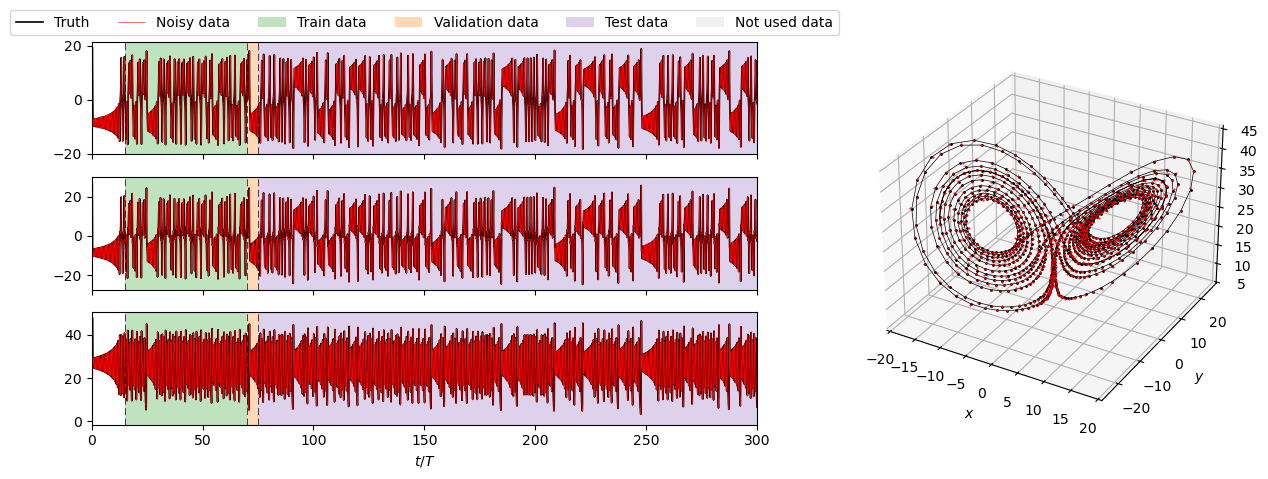

In [4]:
from plot_results import plot_train_dataset

dt = t[1] - t[0]
t_lyap = N_lyap * dt

split_times = [tt / N_lyap for tt in [N_transient, N_train, N_val, N_test]]

plot_train_dataset(clean_data, noisy_data, t/t_lyap, *split_times)

# Initialize the ESN
NB: Different initializations result in different Wout.

In [5]:
import numpy as np

ESN_params = dict(N_wash=5,  # Number of washout steps i.e., open-loop initialization
                  N_units=50,  # Number of neurons 
                  upsample=2, # We want the ESN to predict t + upsample * dt 
                  t_train=N_train * dt,  # Training time
                  t_val=N_val * dt, # Validation time
                  # Training-specific input_parameters
                  N_func_evals=30,
                  N_grid=5,
                  noise=1e-2,
                  Win_type='sparse',
                  N_folds=2,
                  N_split=5,
                  # Hyperparameter optimization ranges
                  rho_range=(.2, .95),
                  sigma_in_range=(np.log10(0.5), np.log10(50.)),
                  tikh_range=[1E-6, 1E-7, 1E-9, 1E-10],
                  random_initialization=True
                  )


# Initialize ESN class
ESN_init = EchoStateNetwork(y=np.zeros((3,1)), 
                       dt=dt, 
                       **ESN_params)


# Train the ESN
The result of the ESN training is the output matrix. We can train the network to input the full state or partial observations.

## a) Full observability


seed 0 	 Optimal hyperparameters: [0.9493366587216259, 0.1756449601456207], 1e-10, MSE: -1.322286539572415

 ----------------- HYPERPARAMETER SEARCH ------------------
 5x5 grid and 5 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 2.000e-01	 5.000e-01	 1.000e-09	 -1.0698
2	 2.000e-01	 1.581e+00	 1.000e-06	 0.1595
3	 2.000e-01	 5.000e+00	 1.000e-06	 -0.6322
4	 2.000e-01	 1.581e+01	 1.000e-06	 -0.6940
5	 2.000e-01	 5.000e+01	 1.000e-06	 -0.0799
6	 3.875e-01	 5.000e-01	 1.000e-07	 1.3890
7	 3.875e-01	 1.581e+00	 1.000e-06	 -0.4526
8	 3.875e-01	 5.000e+00	 1.000e-06	 -0.9690
9	 3.875e-01	 1.581e+01	 1.000e-06	 -0.8942
10	 3.875e-01	 5.000e+01	 1.000e-06	 1.9948
11	 5.750e-01	 5.000e-01	 1.000e-07	 1.2552
12	 5.750e-01	 1.581e+00	 1.000e-06	 0.6501
13	 5.750e-01	 5.000e+00	 1.000e-06	 -1.0306
14	 5.750e-01	 1.581e+01	 1.000e-06	 -0.6274
15	 5.750e-01	 5.000e+01	 1.000e-06	 2.3010
16	 7.625e-01	 5.000e-01	 1.000e-07	 1.6323
17	 7.625e-01	 1.581e+00	 1.000e-06	 0.5587
1

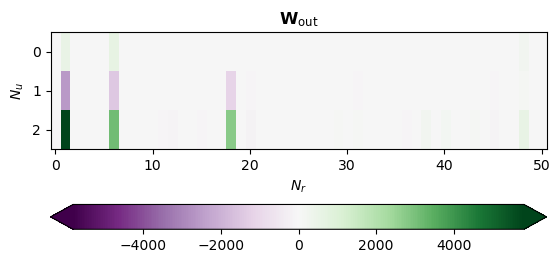

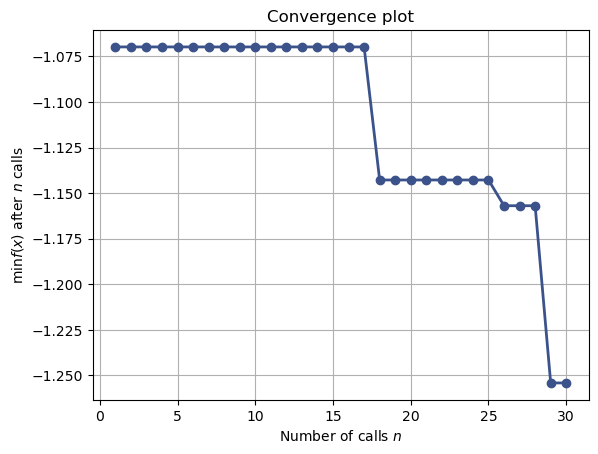

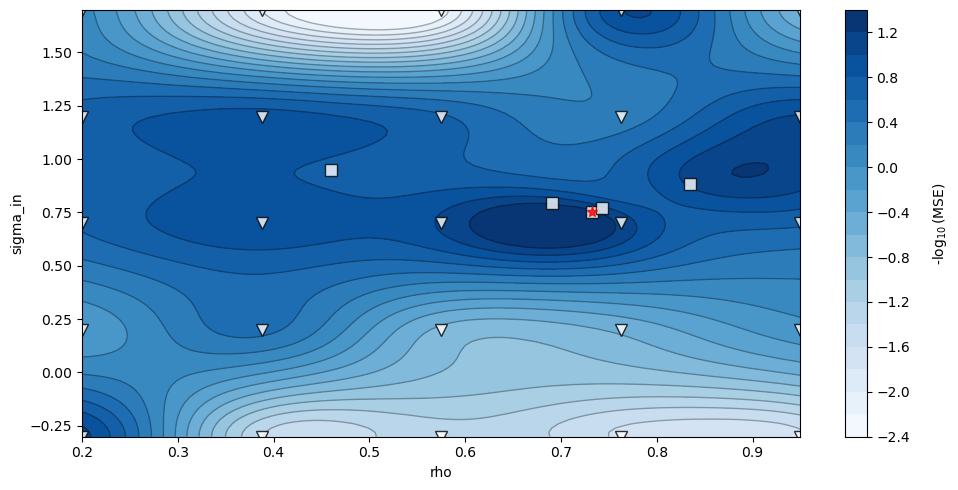

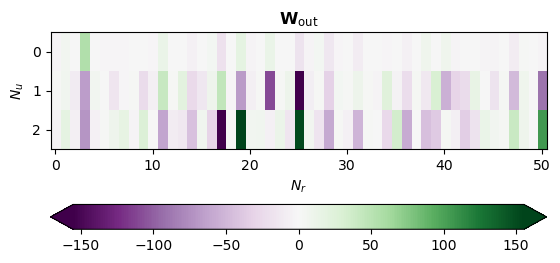

In [6]:
seeds= [0, 252]
for seed in seeds:

    ESN = ESN_init.copy()

    ESN.seed_W = seed
    ESN.train(train_val_data, 
              add_noise=True, 
              plot_training=seed==seeds[-1]
             )
    ESN.plot_Wout()

### Test the long-term prediction

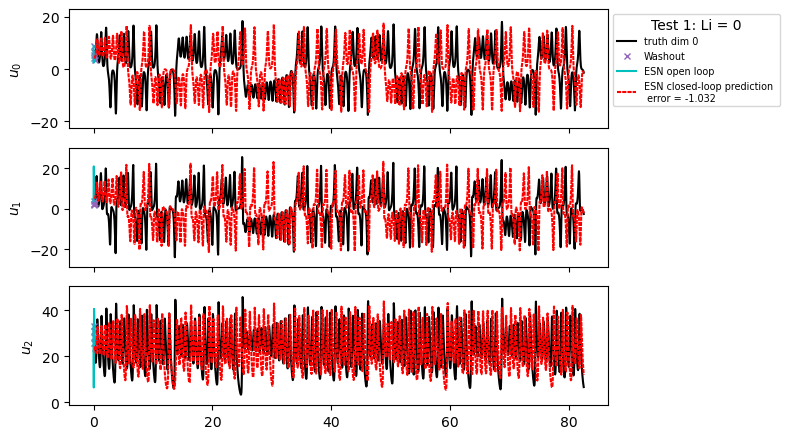

Overall tests min, max and mean MSE in 1 tests = -1.032, -1.032, -1.032.


In [7]:

test_data = noisy_data[-(N_transient+N_train+N_val):]
test_data_clean = clean_data[-(N_transient+N_train+N_val):]  # Truth to compare the tests

upsample_test_data = test_data[::ESN.upsample].copy() # Input
upsample_test_data_clean = test_data_clean[::ESN.upsample].copy() # Truth

ESN.run_test(U_test=upsample_test_data, 
             Y_test=upsample_test_data_clean, 
             Nt_test=len(upsample_test_data), 
             nbins=20)

## b) Partial observability


 ----------------- HYPERPARAMETER SEARCH ------------------
 5x5 grid and 5 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 2.000e-01	 5.000e-01	 1.000e-09	 -1.0187
2	 2.000e-01	 1.581e+00	 1.000e-06	 0.3988
3	 2.000e-01	 5.000e+00	 1.000e-06	 -0.1358
4	 2.000e-01	 1.581e+01	 1.000e-06	 -0.6868
5	 2.000e-01	 5.000e+01	 1.000e-06	 2.4776
6	 3.875e-01	 5.000e-01	 1.000e-06	 1.6106
7	 3.875e-01	 1.581e+00	 1.000e-06	 0.9021
8	 3.875e-01	 5.000e+00	 1.000e-10	 -1.0588
9	 3.875e-01	 1.581e+01	 1.000e-06	 0.6729
10	 3.875e-01	 5.000e+01	 1.000e-06	 2.5932
11	 5.750e-01	 5.000e-01	 1.000e-06	 1.4797
12	 5.750e-01	 1.581e+00	 1.000e-06	 -0.3829
13	 5.750e-01	 5.000e+00	 1.000e-06	 -0.6509
14	 5.750e-01	 1.581e+01	 1.000e-09	 -1.0235
15	 5.750e-01	 5.000e+01	 1.000e-06	 2.4162
16	 7.625e-01	 5.000e-01	 1.000e-06	 1.1876
17	 7.625e-01	 1.581e+00	 1.000e-10	 0.2108
18	 7.625e-01	 5.000e+00	 1.000e-06	 -1.0156
19	 7.625e-01	 1.581e+01	 1.000e-06	 -0.8995
20	 7.625e-01	 5.000

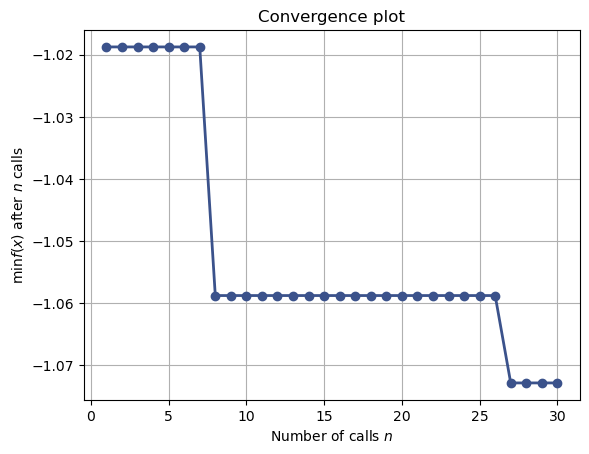

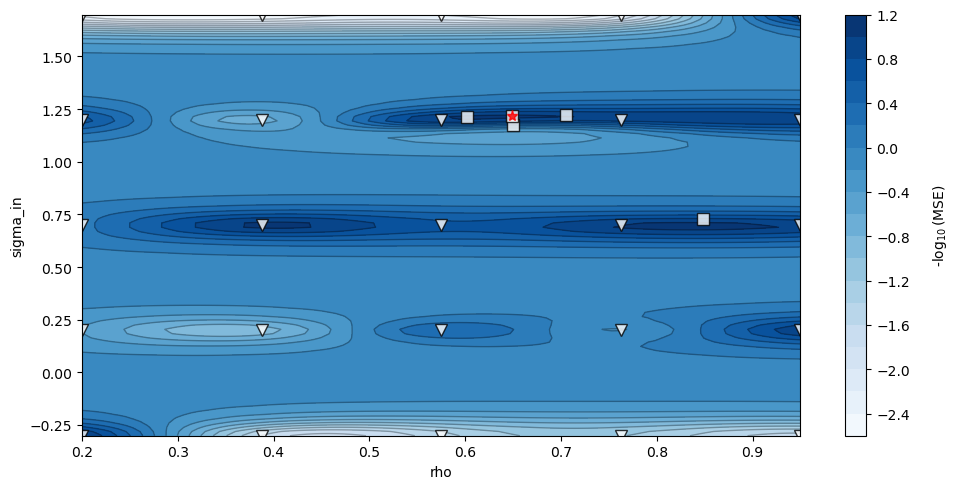

In [8]:

# Define Echo state network input_parameters

ESN_partial = ESN_init.copy()

# Set the observed dimensions
ESN_partial.observed_idx = [0, 2]


ESN_partial.train(train_val_data, 
          add_noise=True, 
          plot_training=True,
         )

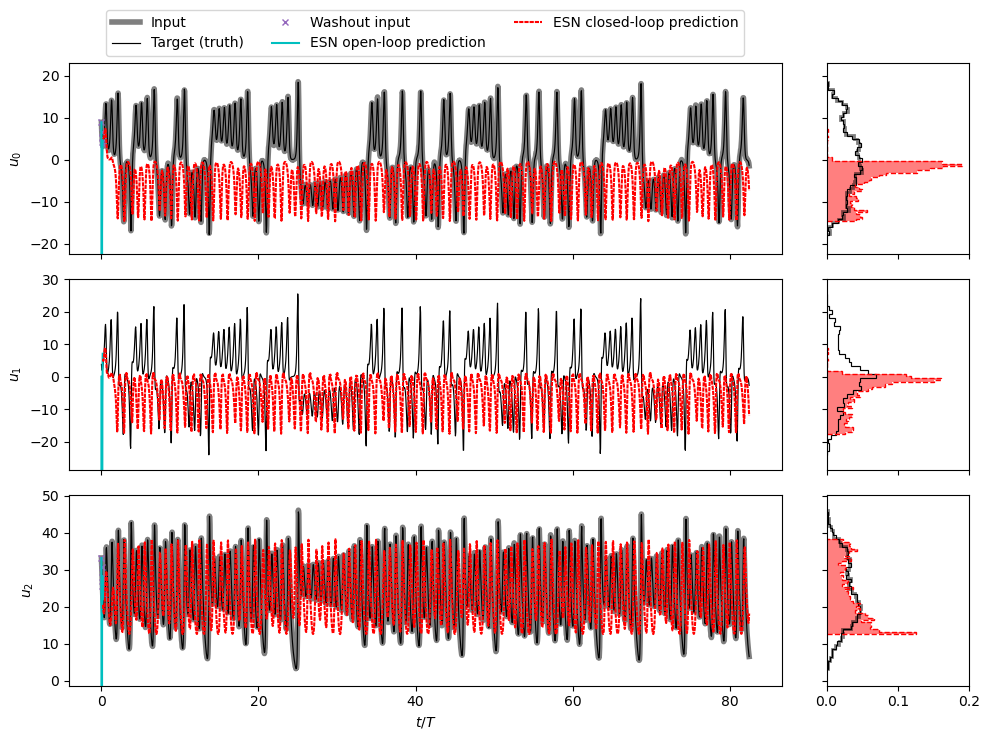

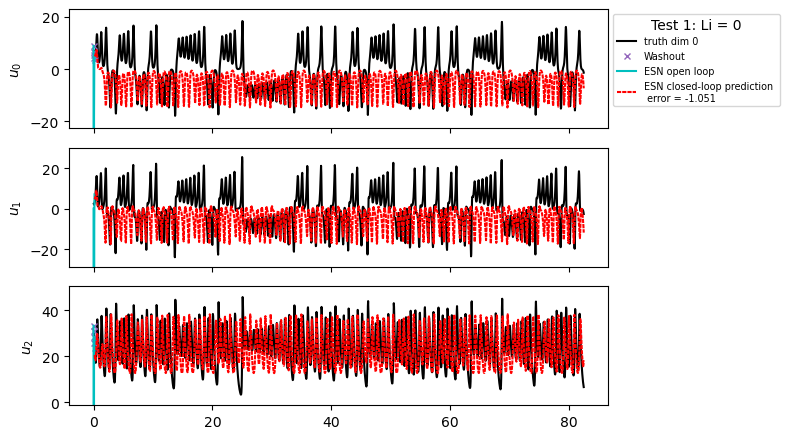

Overall tests min, max and mean MSE in 1 tests = -1.051, -1.051, -1.051.


In [9]:

ESN_partial.run_test(U_test=upsample_test_data[:, ESN_partial.observed_idx], 
             Y_test=upsample_test_data_clean, 
             Nt_test=len(upsample_test_data), 
             plot_pdf=True,
             nbins=40)


The prediction is much worse. Let's try increasing the length of the timeseries

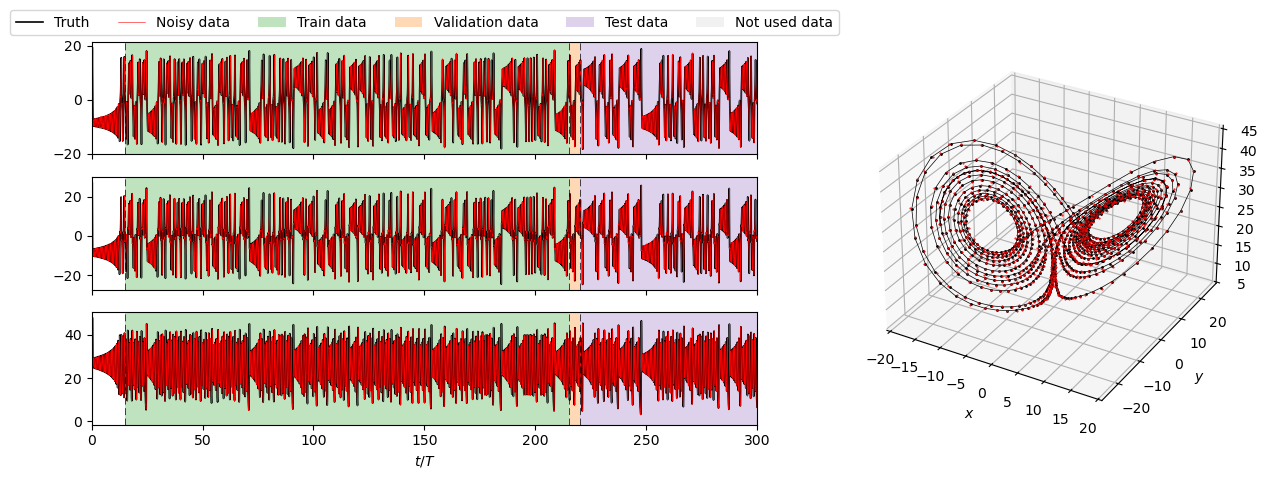

In [10]:
N_train = 200 * N_lyap
N_test = noisy_data.shape[0]-sum((N_train,N_val,N_transient))


train_val_data = noisy_data[N_transient:N_transient+N_train+N_val]

split_times = [tt * dt / t_lyap for tt in [N_transient, N_train, N_val, N_test]]

plot_train_dataset(clean_data, noisy_data, t/t_lyap, *split_times)




 ----------------- HYPERPARAMETER SEARCH ------------------
 5x5 grid and 5 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 2.000e-01	 5.000e-01	 1.000e-10	 -0.9584
2	 2.000e-01	 1.581e+00	 1.000e-06	 0.7265
3	 2.000e-01	 5.000e+00	 1.000e-06	 0.0609
4	 2.000e-01	 1.581e+01	 1.000e-06	 0.3176
5	 2.000e-01	 5.000e+01	 1.000e-06	 2.6886
6	 3.875e-01	 5.000e-01	 1.000e-06	 1.4572
7	 3.875e-01	 1.581e+00	 1.000e-06	 0.9214
8	 3.875e-01	 5.000e+00	 1.000e-06	 -0.6648
9	 3.875e-01	 1.581e+01	 1.000e-06	 0.7806
10	 3.875e-01	 5.000e+01	 1.000e-06	 2.6169
11	 5.750e-01	 5.000e-01	 1.000e-06	 1.6828
12	 5.750e-01	 1.581e+00	 1.000e-06	 0.1719
13	 5.750e-01	 5.000e+00	 1.000e-06	 -1.0426
14	 5.750e-01	 1.581e+01	 1.000e-09	 -1.0673
15	 5.750e-01	 5.000e+01	 1.000e-06	 2.2761
16	 7.625e-01	 5.000e-01	 1.000e-06	 1.4123
17	 7.625e-01	 1.581e+00	 1.000e-10	 -0.3717
18	 7.625e-01	 5.000e+00	 1.000e-06	 -1.0669
19	 7.625e-01	 1.581e+01	 1.000e-07	 -1.0888
20	 7.625e-01	 5.000e+

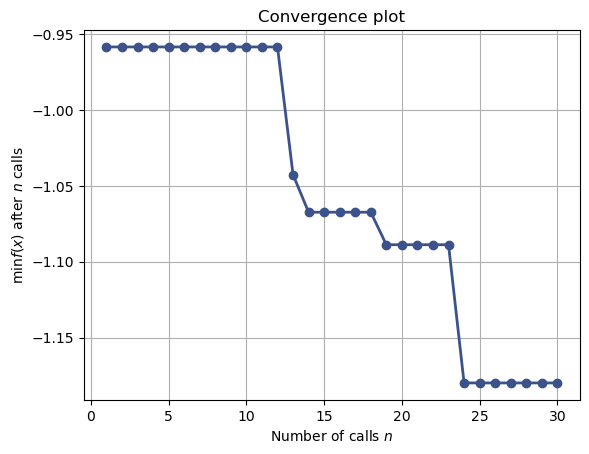

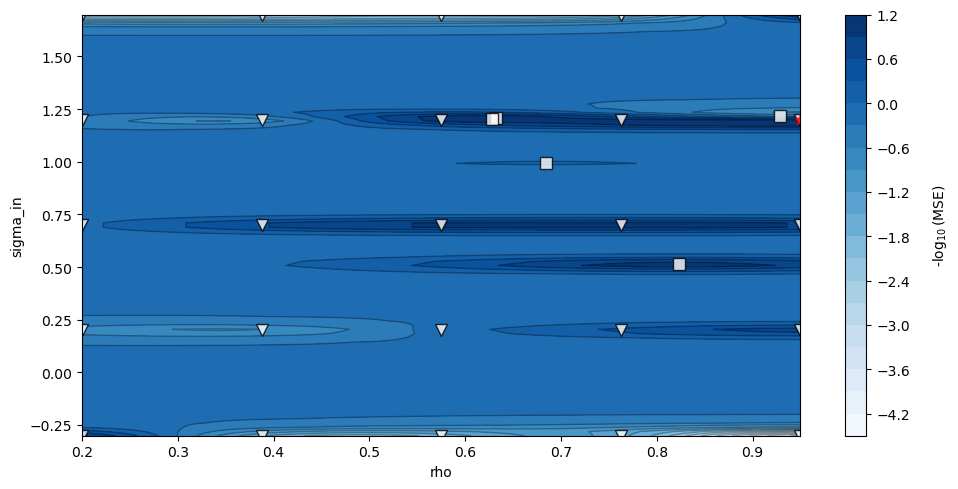

In [11]:

ESN_partial = ESN_init.copy()

# Set the modified properties
ESN_partial.observed_idx = [0, 2]
ESN_partial.t_train = (N_train - N_val) * dt

# Train
ESN_partial.train(train_val_data, 
          add_noise=True, 
          plot_training=True,
         )

### Test the long-term statistics of the partially obseved systems

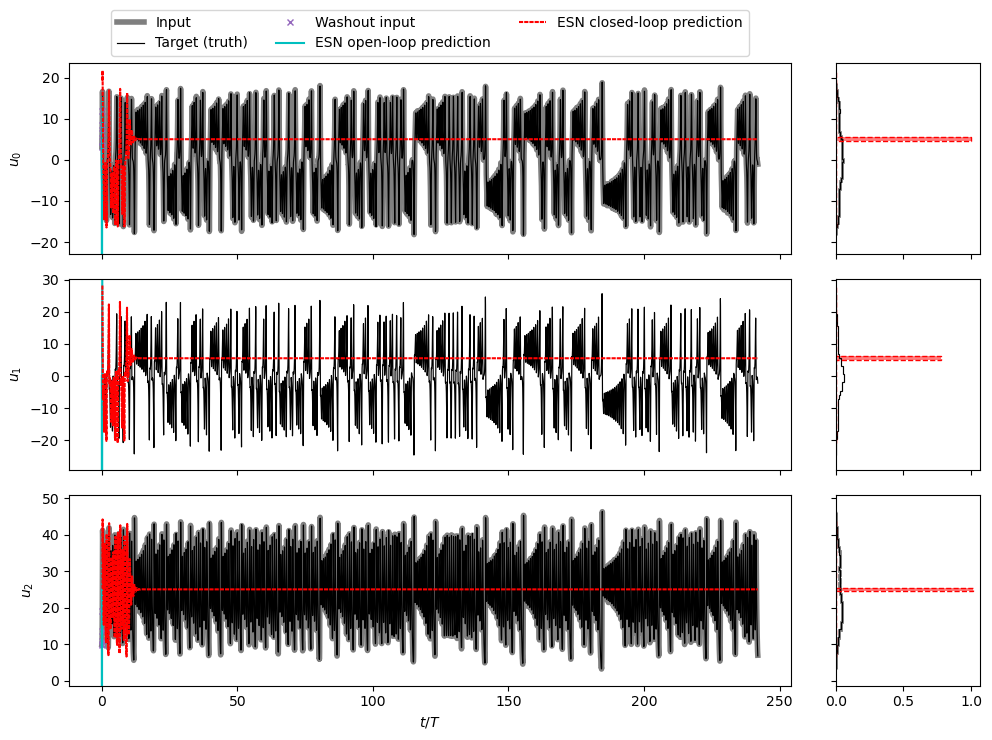

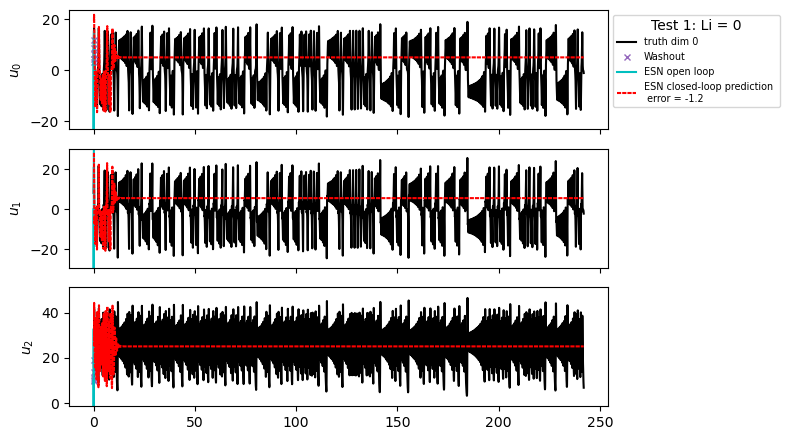

Overall tests min, max and mean MSE in 1 tests = -1.2, -1.2, -1.2.


In [12]:

test_data = noisy_data[-(N_transient+N_train+N_val):]
test_data_clean = clean_data[-(N_transient+N_train+N_val):]  # Truth to compare the tests

upsample_test_data = test_data[::ESN.upsample].copy() # Input
upsample_test_data_clean = test_data_clean[::ESN.upsample].copy() # Truth

ESN_partial.run_test(U_test=upsample_test_data[:, ESN_partial.observed_idx], 
             Y_test=upsample_test_data_clean, 
             Nt_test=len(upsample_test_data), 
             plot_pdf=True,
             nbins=40)
